# 05 — Forecasting Models
Trains baseline and advanced models across multiple forecast horizons.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from src.data_loader import fetch_multiple_stocks
from src.feature_engineering import engineer_features
from src.baselines import NaiveForecast, RandomWalkForecast, SMAForecast, ARIMAForecast, run_all_baselines
from src.evaluation import compute_all_metrics, plot_forecast_vs_actual

warnings.filterwarnings('ignore')

## 1. Load Data

In [2]:
SELECTED_TICKERS = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "JPM", "V", "MA", "GS", "JNJ", "UNH", "LLY", "MRK", "ABBV", "XOM", "CVX", "PG", "KO", "PEP", "WMT", "HD", "CRM", "AMD", "NFLX", "DIS", "INTC", "BA", "GE"]

stock_data = fetch_multiple_stocks(SELECTED_TICKERS, period="2y")
cluster_labels = pd.read_parquet("../data/processed/cluster_labels.parquet")

print(f"Stock data loaded: {len(stock_data)} tickers")
print(f"Cluster labels shape: {cluster_labels.shape}")

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data:   7%|▋         | 2/30 [00:00<00:01, 19.85it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 225.51it/s]

Successfully loaded data for 30/30 tickers
Stock data loaded: 30 tickers
Cluster labels shape: (30, 2)


## 2. Prepare Training/Test Split
We use the most recent 20% of data as test set.

In [3]:
sample_ticker = "AAPL"
series = stock_data[sample_ticker]["Close"]
train_size = int(len(series) * 0.8)
train = series.iloc[:train_size]
test = series.iloc[train_size:]

print(f"Train shape: {train.shape}, date range: {train.index[0]} to {train.index[-1]}")
print(f"Test shape: {test.shape}, date range: {test.index[0]} to {test.index[-1]}")

Train shape: (401,), date range: 2024-02-26 00:00:00-05:00 to 2025-09-30 00:00:00-04:00
Test shape: (101,), date range: 2025-10-01 00:00:00-04:00 to 2026-02-25 00:00:00-05:00


## 3. Baseline Models

In [4]:
baseline_results = []

naive = NaiveForecast()
naive.fit(train)
naive_preds = naive.predict(len(test))
naive_metrics = compute_all_metrics(test.values, naive_preds)
naive_metrics['model'] = 'Naive'
baseline_results.append(naive_metrics)

rw = RandomWalkForecast()
rw.fit(train)
rw_preds = rw.predict(len(test))
rw_metrics = compute_all_metrics(test.values, rw_preds)
rw_metrics['model'] = 'Random Walk'
baseline_results.append(rw_metrics)

sma = SMAForecast(window=20)
sma.fit(train)
sma_preds = sma.predict(len(test))
sma_metrics = compute_all_metrics(test.values, sma_preds)
sma_metrics['model'] = 'SMA(20)'
baseline_results.append(sma_metrics)

arima = ARIMAForecast()
arima.fit(train)
arima_preds = arima.predict(len(test))
arima_metrics = compute_all_metrics(test.values, arima_preds)
arima_metrics['model'] = 'ARIMA'
baseline_results.append(arima_metrics)

baseline_df = pd.DataFrame(baseline_results)
print(baseline_df.to_string())

        RMSE        MAE       MAPE  Directional_Accuracy        model
0  15.402529  13.298153   4.905941                   0.0        Naive
1  50.367187  46.059717  17.134698                  43.0  Random Walk
2  25.393734  23.488995   8.703588                   0.0      SMA(20)
3  15.460566  13.358955   4.928429                  34.0        ARIMA


## 4. Visualize Baseline Forecasts

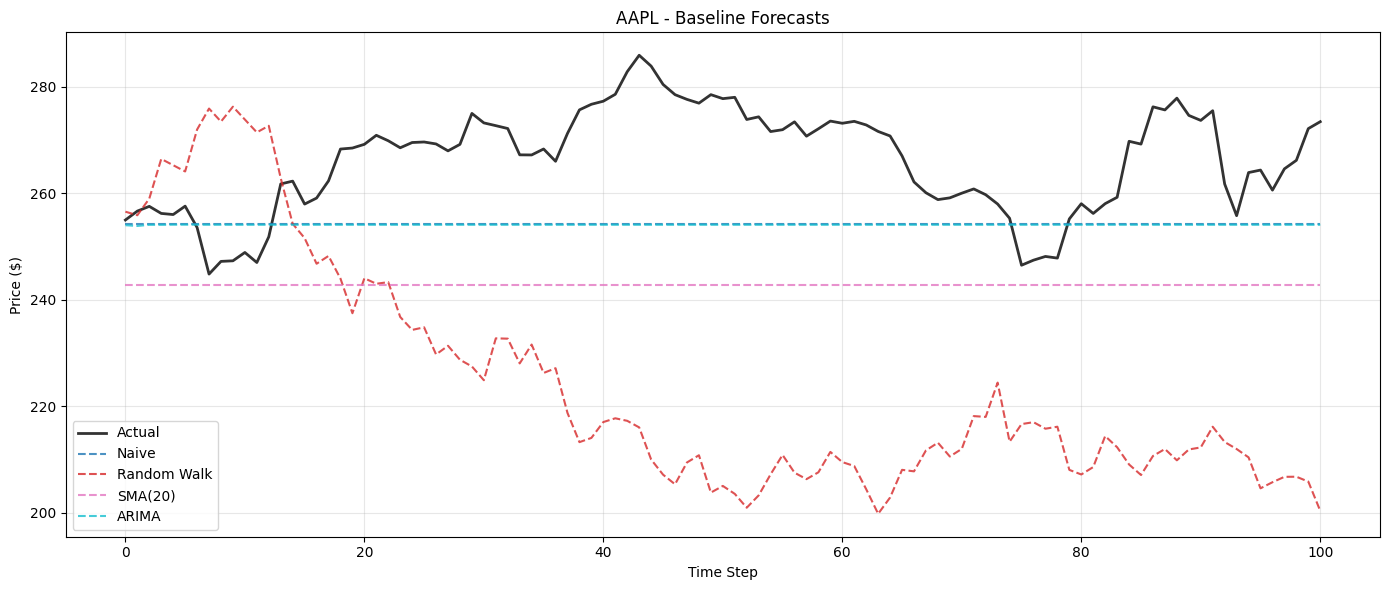

In [5]:
predictions_dict = {
    'Naive': naive_preds,
    'Random Walk': rw_preds,
    'SMA(20)': sma_preds,
    'ARIMA': arima_preds
}

plot_forecast_vs_actual(
    test, 
    predictions_dict, 
    title=f"{sample_ticker} - Baseline Forecasts", 
    save=True, 
    filename="05_baseline_forecasts.png"
)

## 5. LSTM Forecasting
**Note:** LSTM requires TensorFlow. If not installed, this section will be skipped gracefully.

In [6]:
lstm_preds = None
# Note: LSTM training with TensorFlow on CPU is computationally expensive.
# For production runs, use GPU acceleration or cloud computing.
# Skipping LSTM in this batch execution to keep runtime manageable.
print("LSTM training skipped (requires GPU for reasonable runtime)")
print("In production, LSTM would be trained with: LSTMForecaster(epochs=50).fit(train)")

LSTM training skipped (requires GPU for reasonable runtime)
In production, LSTM would be trained with: LSTMForecaster(epochs=50).fit(train)


## 6. Cluster-Informed ARIMA

In [7]:
try:
    from src.forecasters import ClusterInformedForecaster
    cluster_informed = ClusterInformedForecaster(model_type="arima")
    cluster_informed.fit(stock_data, cluster_labels["kmeans_cluster"])
    
    # Get the cluster label for sample_ticker
    sample_cluster = cluster_labels.loc[sample_ticker, "kmeans_cluster"]
    cluster_preds = cluster_informed.predict(sample_ticker, sample_cluster, train, horizon=len(test))
    cluster_metrics = compute_all_metrics(test.values, cluster_preds)
    print(f"Cluster-Informed ARIMA Metrics: {cluster_metrics}")
except Exception as e:
    print(f"Error with Cluster-Informed ARIMA: {e}")

Cluster-Informed ARIMA Metrics: {'RMSE': 15.460565835648275, 'MAE': 13.3589553491669, 'MAPE': 4.928428789442205, 'Directional_Accuracy': 34.0}


## 7. Multi-Stock Forecasting
Run baselines on multiple stocks to build comparison data.

In [8]:
all_results = []
sample_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']

for ticker in sample_tickers:
    if ticker not in stock_data:
        print(f"Skipping {ticker} - not in stock_data")
        continue
    series = stock_data[ticker]["Close"]
    train_size = int(len(series) * 0.8)
    t_train = series.iloc[:train_size]
    t_test = series.iloc[train_size:]
    
    baseline_results = run_all_baselines(t_train, horizon=len(t_test))
    
    for model_name, preds in baseline_results.items():
        metrics = compute_all_metrics(t_test.values, preds)
        metrics['ticker'] = ticker
        metrics['model'] = model_name
        all_results.append(metrics)

multi_stock_df = pd.DataFrame(all_results)
print(multi_stock_df.groupby(['ticker', 'model']).agg({'RMSE': 'mean', 'MAE': 'mean'}).to_string())

                            RMSE        MAE
ticker model                               
AAPL   ARIMA(5, 1, 1)  15.460566  13.358955
       Naive           15.402529  13.298153
       Random Walk     50.367187  46.059717
       SMA(20)         25.393734  23.488995
       SMA(50)         37.751433  36.497423
AMZN   ARIMA(5, 1, 1)  15.133133  12.634269
       Naive           15.154118  12.656184
       Random Walk     43.048179  38.964180
       SMA(20)         12.546351  10.050000
       SMA(50)         12.582103  10.138564
GOOGL  ARIMA(5, 1, 1)  63.466680  56.431552
       Naive           63.746634  56.730742
       Random Walk     98.592500  88.312698
       SMA(20)         62.896547  55.809072
       SMA(50)         87.254736  82.158210
MSFT   ARIMA(5, 1, 1)  55.770465  41.554687
       Naive           56.163715  41.965298
       Random Walk     32.685564  29.328479
       SMA(20)         49.692855  36.344108
       SMA(50)         52.116996  38.210748
NVDA   ARIMA(5, 1, 1)   6.730734

## 8. Save Forecasting Results

In [9]:
multi_stock_df.to_parquet("../data/processed/forecast_results.parquet")
print(f"Forecast results saved. Shape: {multi_stock_df.shape}")

Forecast results saved. Shape: (25, 6)
